<a href="https://colab.research.google.com/github/subhadeepk/cse437-assignments/blob/main/lab4_dyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


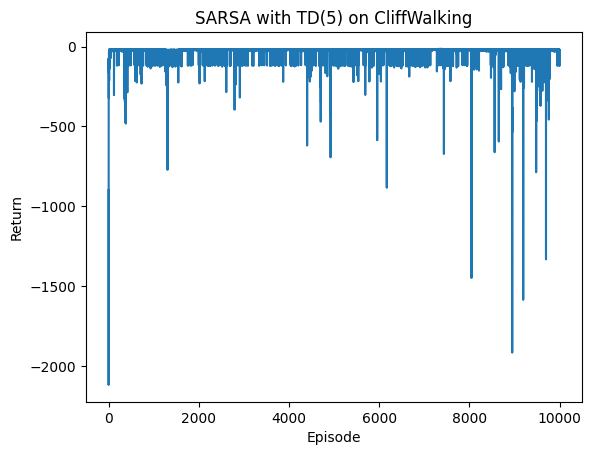

[-20, -19, -21, -20, -19, -26, -21, -24, -122, -21]


In [38]:
"""
Starter code for Exercise (you can use this code, or extend your code from previous lab)
Implement SARSA with TD(5) on CliffWalking-v1
"""

import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt

# Environment
env = gym.make("CliffWalking-v1")

# Parameters
n_states = env.observation_space.n
n_actions = env.action_space.n
alpha = 0.1           # step size (learning rate)
gamma = 0.99          # discount factor
epsilon = 0.1         # epsilon for epsilon-greedy policy
n_step = 5            # number of steps for TD(n)
n_episodes = 1000
eps = 1

# Initialize Q-table
Q = np.zeros((n_states, n_actions))

def epsilon_greedy(state):
    """Choose an action using epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

# Track returns
episode_returns = []
# ε schedule (episode-wise exponential decay)
eps_min, eps_max, eps_decay = 0.05, 1.0, 5e-2

for ep in range(n_episodes):
    state, _ = env.reset()
    action = epsilon_greedy(state)
    eps = max(eps_min, (ep/n_episodes)*eps_max)  # uniform per-step decay
    if n_episodes - ep < 10:
        eps = 0
    # eps = max(eps_min, eps * (1 - eps_decay))

    # Buffers to store the trajectory
    # states = deque()
    # actions = deque()
    # rewards = deque()

    states = []
    actions = []
    rewards = []

    T = float("inf")
    t = 0
    G = 0
    done = False

    while True:
        if t < T:
            # Take real step in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            states.append(state)
            actions.append(action)
            rewards.append(reward)

            if done:
                T = t + 1
            else:
                next_action = epsilon_greedy(next_state)
                state = next_state
                action = next_action

        # Time index for state/action to update
        tau = t - n_step + 1
        if tau >= 0:
            # TODO: Compute the n-step return G for state tau
            # Hint: use rewards[tau : tau+n] plus Q(s_t+n, a_t+n) if not terminal

            # Example structure:
            G = 0.0
            # accumulate discounted rewards
            for i in range(tau, min(tau + n_step, T)):
                G += (gamma ** (i - tau)) * rewards[i]
            if tau + n_step < T:
                # print(tau + n_step)
                # print(len(states))
                s_tau_n = states[tau + n_step - 1]
                a_tau_n = actions[tau + n_step - 1]
                G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

            # TODO: Update Q[states[tau], actions[tau]] toward G
            Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])

        if tau == T - 1:
            break

        t += 1

    episode_returns.append(sum(rewards))

# Plot learning curve
plt.plot(episode_returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("SARSA with TD(5) on CliffWalking")
plt.show()


## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




In [85]:
# Dyna Q

import gymnasium as gym
import numpy as np
import random

env = gym.make("CliffWalking-v1")

def dynaQ(N_sim = 50, n_episodes = 25):

  alpha = 0.1
  gamma = 0.95
  n_actions = env.action_space.n
  n_states = env.observation_space.n
  Q = np.zeros((n_states, n_actions))
  dyna_q_learning_rewards = []
  Experience = []
  eps = 1

  max_steps = 100

  # epsilon schedule (episode-wise exponential decay)
  eps_min, eps_max, eps_decay = 0.05, 1.0, 5e-3

  def eps_greedy(s, eps):
      if random.random() < eps:
          return env.action_space.sample()
      return int(np.argmax(Q[s]))

  for ep in range(n_episodes):
      s, _ = env.reset()
      # decay epsilon per episode
      # eps = eps_min + (eps_max - eps_min) * np.exp(-eps_decay * ep)
      eps = max(eps_min, (ep/n_episodes)*eps_max)  # uniform per-step decay

      if ep>5:
        eps = 0

      episode_reward = 0

      a = eps_greedy(s, eps)

      for t in range(max_steps):
          s_next, r, terminated, truncated, _ = env.step(a)
          Experience.append((s, a, r, s_next))


          # if ep == n_episodes - 1:
          #     q_learning_rewards.append(r)

          episode_reward += r

          # Q update
          if terminated or truncated:
              Q[s, a] += alpha * (r - Q[s, a])
              break

          # choose a_next as the best action for Q update
          a_next = np.argmax(Q[s_next])

          # Q update
          td_target = r + gamma * Q[s_next, a_next]
          Q[s, a] += alpha * (td_target - Q[s, a])

          for _ in range(N_sim):
              s_sim, a_sim, r_sim, s_next_sim = random.choice(Experience)
              a_next = np.argmax(Q[s_next_sim])
              td_target = r_sim + gamma * Q[s_next_sim, a_next]
              Q[s_sim, a_sim] += alpha * (td_target - Q[s_sim, a_sim])

          a_next_actual = eps_greedy(s_next, eps)
          s, a = s_next, a_next_actual

      dyna_q_learning_rewards.append(episode_reward)


  plt.figure(figsize=(12, 6))
  plt.plot(dyna_q_learning_rewards, label=f"Dyna Q, n = {N_sim}")
  plt.xlabel("Episode")
  plt.ylabel("Return")
  plt.title(f"Dyna Q Returns per Episode, n = {N_sim}")
  plt.legend()
  plt.grid(True)
  plt.show()
  return(dyna_q_learning_rewards)





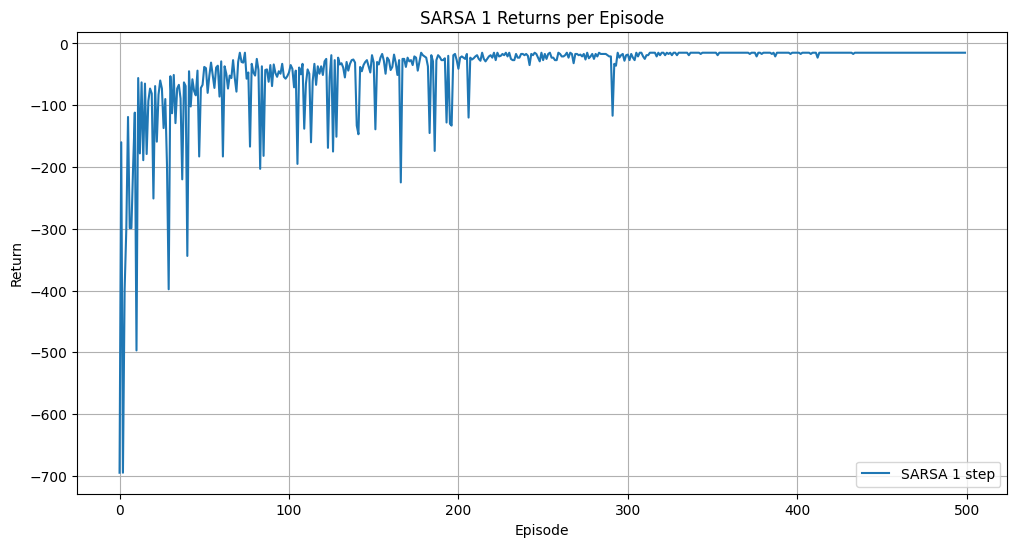

In [61]:
# SARSA 1 step

import gymnasium as gym
import numpy as np
import random

def sarsa_1():

  # ---- Reproducibility ----
  SEED = 0
  random.seed(SEED)
  np.random.seed(SEED)

  env = gym.make("CliffWalking-v1")
  env.reset(seed=SEED)
  try:
      env.action_space.seed(SEED)
  except AttributeError:
      pass

  # SARSA parameters
  alpha = 0.1
  gamma = 0.95
  n_actions = env.action_space.n
  n_states = env.observation_space.n
  Q = np.zeros((n_states, n_actions), dtype=np.float64)

  # ε schedule (episode-wise exponential decay)
  eps_min, eps_max, eps_decay = 0.05, 1.0, 5e-2
  eps = 1

  n_episodes = 300
  max_steps = 200


  sarsa_1_returns = []  # episode returns

  def eps_greedy(state, eps):
      if random.random() < eps:
          return env.action_space.sample()
      return int(np.argmax(Q[state]))

  for ep in range(n_episodes):
      s, _ = env.reset()
      eps = max(eps_min, eps * (1 - eps_decay))  # tiny per-step decay
      if n_episodes - ep < 10:
        eps = 0

      a = eps_greedy(s, eps)
      ep_return = 0.0

      for t in range(max_steps):
          s_next, r, terminated, truncated, _ = env.step(a)
          ep_return += r
          done = terminated or truncated

          # choose a' only if not terminal
          if not done:
              a_next = eps_greedy(s_next, eps)

          td_target = r + (0.0 if done else gamma * Q[s_next, a_next])
          Q[s, a] += alpha * (td_target - Q[s, a])

          if done:
              break

          s, a = s_next, a_next

      sarsa_1_returns.append(ep_return)

  plt.figure(figsize=(12, 6))
  plt.plot(returns, label="SARSA 1 step")
  plt.xlabel("Episode")
  plt.ylabel("Return")
  plt.title("SARSA 1 Returns per Episode")
  plt.legend()
  plt.grid(True)
  plt.show()

  return sarsa_1_returns

sarsa_1_returns = sarsa_1()



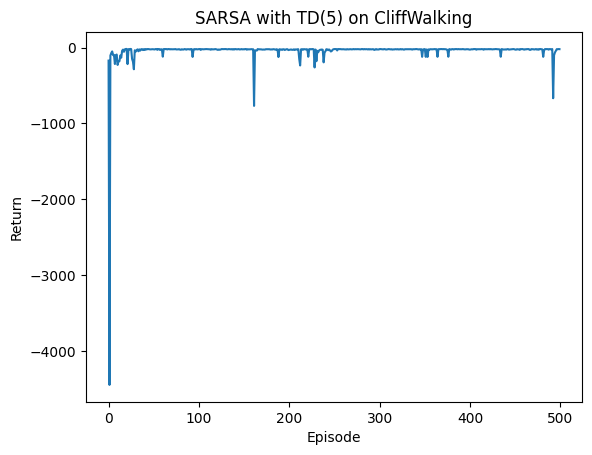

In [62]:
# TD 5 SARSA

import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt

def td_5_sarsa():
  # Environment
  env = gym.make("CliffWalking-v1")

  # Parameters
  n_states = env.observation_space.n
  n_actions = env.action_space.n
  alpha = 0.1           # step size (learning rate)
  gamma = 0.99          # discount factor
  epsilon = 0.1         # epsilon for epsilon-greedy policy
  n_step = 5            # number of steps for TD(n)
  n_episodes = 500
  eps = 1

  # Initialize Q-table
  Q = np.zeros((n_states, n_actions))

  def epsilon_greedy(state):
      """Choose an action using epsilon-greedy policy."""
      if np.random.rand() < epsilon:
          return np.random.randint(n_actions)
      return np.argmax(Q[state])

  # Track returns
  episode_returns = []
  # ε schedule (episode-wise exponential decay)
  eps_min, eps_max, eps_decay = 0.05, 1.0, 5e-2

  for ep in range(n_episodes):
      state, _ = env.reset()
      action = epsilon_greedy(state)
      eps = max(eps_min, (ep/n_episodes)*eps_max)  # uniform per-step decay
      if n_episodes - ep < 20:
          eps = 0
      # eps = max(eps_min, eps * (1 - eps_decay))

      # Buffers to store the trajectory
      # states = deque()
      # actions = deque()
      # rewards = deque()

      states = []
      actions = []
      rewards = []

      T = float("inf")
      t = 0
      G = 0
      done = False

      while True:
          if t < T:
              # Take real step in the environment
              next_state, reward, terminated, truncated, _ = env.step(action)
              done = terminated or truncated

              states.append(state)
              actions.append(action)
              rewards.append(reward)

              if done:
                  T = t + 1
              else:
                  next_action = epsilon_greedy(next_state)
                  state = next_state
                  action = next_action

          # Time index for state/action to update
          tau = t - n_step + 1
          if tau >= 0:
              # TODO: Compute the n-step return G for state tau
              # Hint: use rewards[tau : tau+n] plus Q(s_t+n, a_t+n) if not terminal

              # Example structure:
              G = 0.0
              # accumulate discounted rewards
              for i in range(tau, min(tau + n_step, T)):
                  G += (gamma ** (i - tau)) * rewards[i]
              if tau + n_step < T:
                  # print(tau + n_step)
                  # print(len(states))
                  s_tau_n = states[tau + n_step - 1]
                  a_tau_n = actions[tau + n_step - 1]
                  G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

              # TODO: Update Q[states[tau], actions[tau]] toward G
              Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])

          if tau == T - 1:
              break

          t += 1

      episode_returns.append(sum(rewards))

  # Plot learning curve
  plt.plot(episode_returns)
  plt.xlabel("Episode")
  plt.ylabel("Return")
  plt.title("SARSA with TD(5) on CliffWalking")
  plt.show()

  return episode_returns

td5_returns = td_5_sarsa()

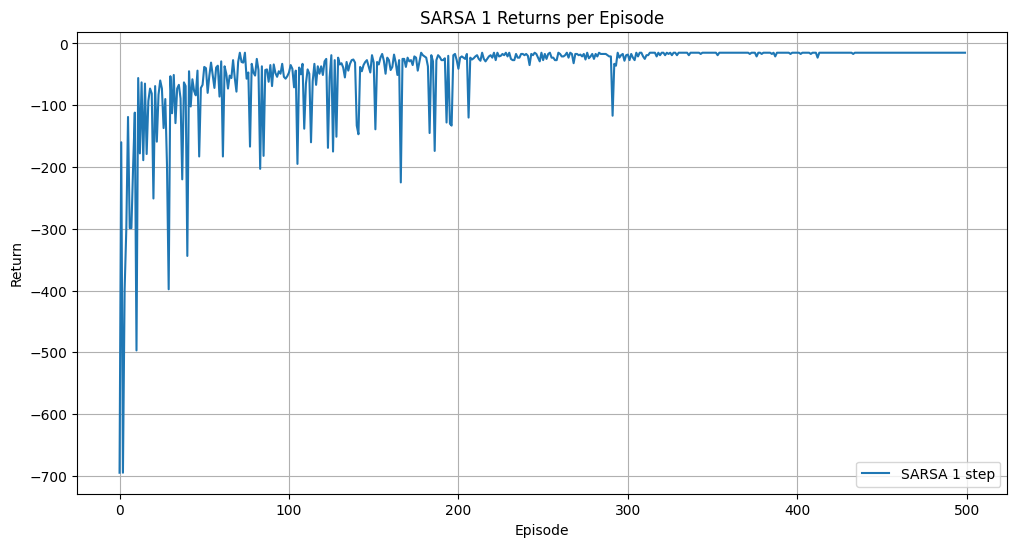

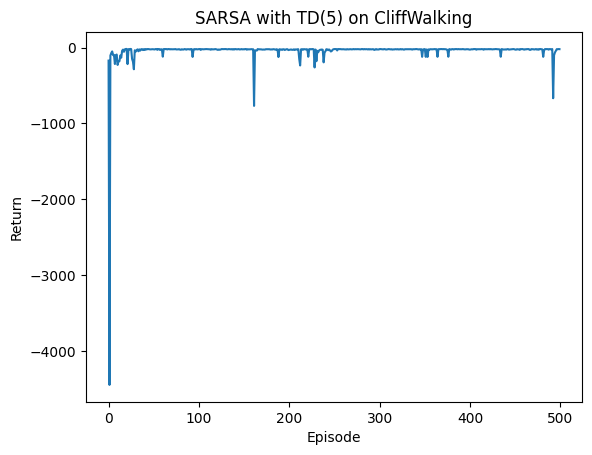

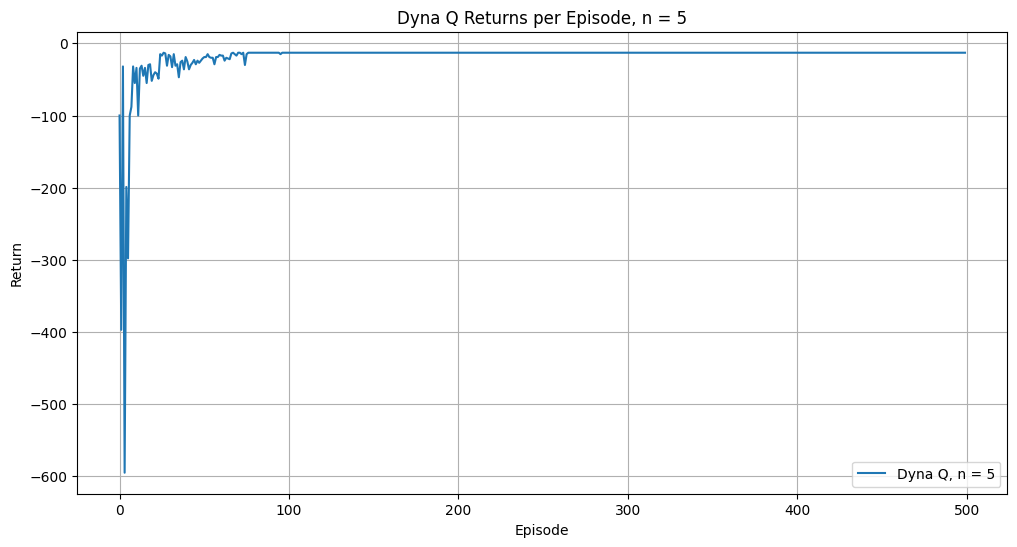

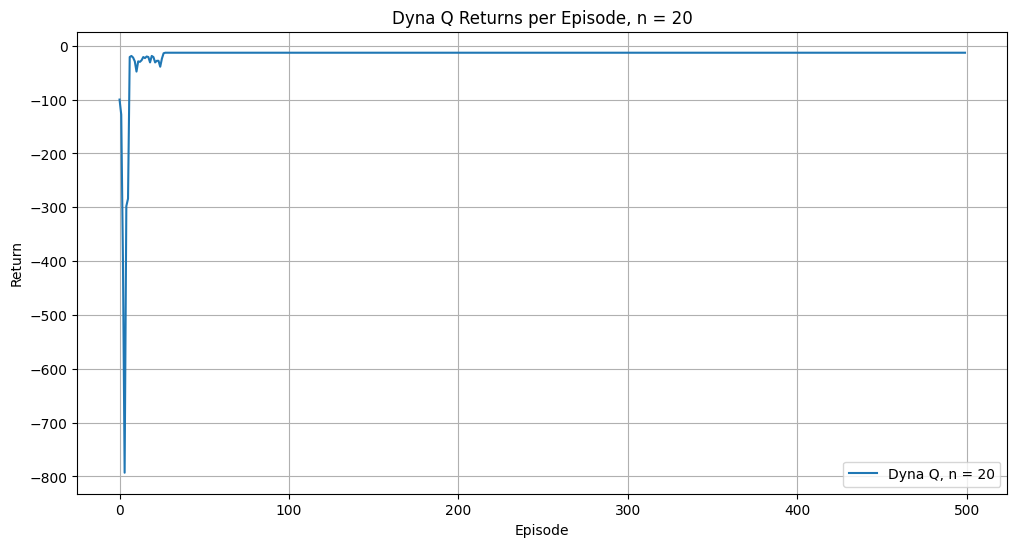

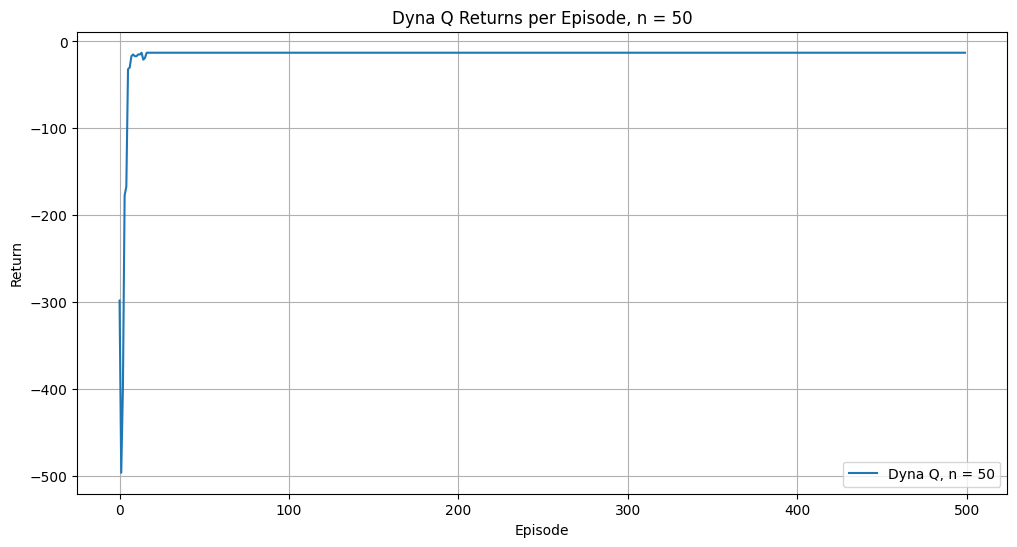

[-100, -128, -397, -793, -298, -284, -21, -19, -22, -29, -48, -29, -30, -27, -21, -23, -20, -21, -31, -19, -21, -31, -28, -28, -39, -24, -14, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13

In [86]:
# Run all algorithms and collect returns

sarsa_1_returns = sarsa_1()
td5_returns = td_5_sarsa()
dynaQ5_returns = dynaQ(N_sim = 5, n_episodes=500)
dynaQ20_returns = dynaQ(N_sim = 20, n_episodes=500)
dynaQ50_returns = dynaQ(N_sim = 50, n_episodes=500)
print(dynaQ20_returns)

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?

Dyna Q hugs the cliff, SARSA methods are safer

4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.

Dyna  
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

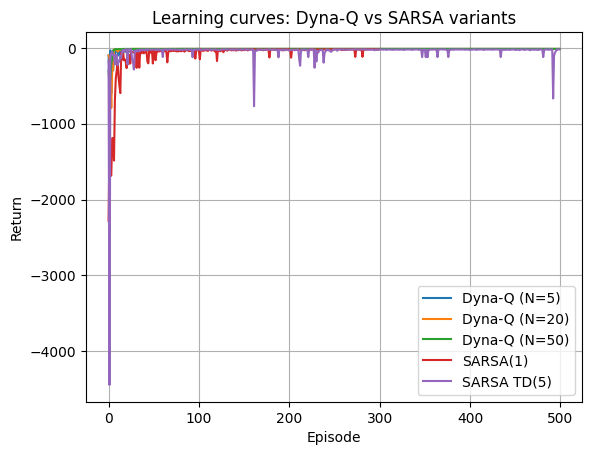


Sample efficiency: first episode where 50-ep moving avg > -30
  Dyna-Q (N=5)   -> 10
  Dyna-Q (N=20)  -> 4
  Dyna-Q (N=50)  -> 2
  SARSA(1)       -> 112
  SARSA TD(5)    -> 29

Stability (heuristic, last 100 episodes):
  Dyna-Q (N=5)   -> mean_last=-13.00, cliff_fall_frac=0.000, verdict=Near-optimal: likely hugging the cliff
  Dyna-Q (N=20)  -> mean_last=-13.00, cliff_fall_frac=0.000, verdict=Near-optimal: likely hugging the cliff
  Dyna-Q (N=50)  -> mean_last=-13.00, cliff_fall_frac=0.000, verdict=Near-optimal: likely hugging the cliff
  SARSA(1)       -> mean_last=-24.19, cliff_fall_frac=0.030, verdict=Mixed: some margin or occasional slips
  SARSA TD(5)    -> mean_last=-31.75, cliff_fall_frac=0.040, verdict=Mixed: some margin or occasional slips

Dyna-Q sensitivity (final 50 episodes mean ± std across seeds if provided):
  Dyna-Q (N=5)   -> -13.00 ± 0.00
  Dyna-Q (N=20)  -> -13.00 ± 0.00
  Dyna-Q (N=50)  -> -13.00 ± 0.00


In [88]:
import numpy as np
import matplotlib.pyplot as plt

# ===== Helpers =====
def to_2d(arr_or_list):
    """Accept [T] or list of [T] (multi-seed) and return shape [S, T] with S>=1."""
    if isinstance(arr_or_list, (list, tuple)) and len(arr_or_list)>0 and hasattr(arr_or_list[0], "__len__"):
        # list of arrays (multi-seed)
        L = [np.asarray(a).reshape(-1) for a in arr_or_list]
        T = min(len(a) for a in L)
        return np.stack([a[:T] for a in L], axis=0)
    else:
        a = np.asarray(arr_or_list).reshape(-1)
        return a[None, :]  # [1, T]

def moving_avg(x, window=100):
    if window <= 1:
        return x.copy()
    if x.ndim == 1:
        return np.convolve(x, np.ones(window)/window, mode='valid')
    # [S, T]
    T = x.shape[1]
    out = []
    for s in range(x.shape[0]):
        out.append(np.convolve(x[s], np.ones(window)/window, mode='valid'))
    return np.stack(out, axis=0)

def first_crossing(ma, threshold):
    """Return first index (episode) where moving average exceeds threshold; None if never."""
    if ma.ndim == 2:  # multi-seed: use mean across seeds
        ma = ma.mean(axis=0)
    idx = np.where(ma > threshold)[0]
    return int(idx[0]) if idx.size else None

def final_mean_std(returns_2d, last_k=50):
    """Mean±std across seeds of the final K-episode average per seed."""
    returns_2d = np.asarray(returns_2d)
    T = returns_2d.shape[1]
    last = returns_2d[:, max(0, T-last_k):]
    per_seed_means = last.mean(axis=1)
    return float(per_seed_means.mean()), float(per_seed_means.std(ddof=1) if len(per_seed_means)>1 else 0.0)

def stability_from_returns(returns_2d, last_k=100):
    """Heuristic: infer behavior near the cliff from returns alone."""
    R = returns_2d if returns_2d.ndim==2 else returns_2d[None, :]
    T = R.shape[1]
    tail = R[:, max(0, T-last_k):]
    mean_last = float(tail.mean())
    frac_falls = float((tail <= -100).mean())  # falls into cliff in CliffWalking = -100 penalty
    # crude verdict rules of thumb:
    if frac_falls > 0.10:
        verdict = "Unstable: frequent cliff falls"
    elif mean_last > -16:  # ~near-optimal hugging
        verdict = "Near-optimal: likely hugging the cliff"
    elif mean_last > -40:
        verdict = "Mixed: some margin or occasional slips"
    else:
        verdict = "Conservative: likely leaves a safer margin"
    return dict(ep=last_k, mean_last=mean_last, frac_falls=frac_falls, verdict=verdict)

def plot_learning_curves(curves_dict, smooth=1, title="Learning Curves (episode return)"):
    plt.figure()
    for name, arr in curves_dict.items():
        M = to_2d(arr)           # [S, T]
        mean = M.mean(axis=0)
        if smooth>1:
            mean_plot = moving_avg(mean, smooth)
            x = np.arange(len(mean_plot)) + (smooth-1)
        else:
            mean_plot = mean
            x = np.arange(len(mean_plot))
        plt.plot(x, mean_plot, label=name)
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_mean_with_band(name, arr, smooth=1):
    """Mean ± std over seeds (or over a bootstrap of 1 seed -> no band)."""
    M = to_2d(arr)  # [S, T]
    mean = M.mean(axis=0)
    std  = M.std(axis=0, ddof=1) if M.shape[0] > 1 else np.zeros_like(mean)
    if smooth>1:
        mean = moving_avg(mean, smooth)
        std  = moving_avg(std, smooth)
        x = np.arange(len(mean)) + (smooth-1)
    else:
        x = np.arange(len(mean))
    plt.figure()
    plt.plot(x, mean, label=f"{name} (mean)")
    if M.shape[0] > 1:
        plt.fill_between(x, mean-std, mean+std, alpha=0.2, label="±1 std")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title(f"{name}: mean ± std over seeds")
    plt.legend()
    plt.grid(True)
    plt.show()

# ======= Use your five series =======
curves = {
    "Dyna-Q (N=5)":  dynaQ5_returns,
    "Dyna-Q (N=20)": dynaQ20_returns,
    "Dyna-Q (N=50)": dynaQ50_returns,
    "SARSA(1)":      sarsa_1_returns,
    "SARSA TD(5)":   td5_returns,
}

# 1) Learning curves (no subplots; multiple lines in one figure).
plot_learning_curves(curves, smooth=1, title="Learning curves: Dyna-Q vs SARSA variants")

# 2) Sample efficiency (sliding window threshold crossing)
WINDOW = 50
THRESH = -30
print(f"\nSample efficiency: first episode where {WINDOW}-ep moving avg > {THRESH}")
for name, arr in curves.items():
    M = to_2d(arr)
    ma = moving_avg(M, window=WINDOW)
    idx = first_crossing(ma, THRESH)
    print(f"  {name:14s} -> {idx}")

# 3) Stability heuristic near the cliff (from returns only)
print("\nStability (heuristic, last 100 episodes):")
for name, arr in curves.items():
    info = stability_from_returns(to_2d(arr), last_k=100)
    print(f"  {name:14s} -> mean_last={info['mean_last']:.2f}, cliff_fall_frac={info['frac_falls']:.3f}, verdict={info['verdict']}")

# 4) Sensitivity to planning steps (Dyna-Q only): compare final-50 performance
print("\nDyna-Q sensitivity (final 50 episodes mean ± std across seeds if provided):")
for name in ["Dyna-Q (N=5)", "Dyna-Q (N=20)", "Dyna-Q (N=50)"]:
    mu, sd = final_mean_std(to_2d(curves[name]), last_k=50)
    print(f"  {name:14s} -> {mu:.2f} ± {sd:.2f}")

## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- ** Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).


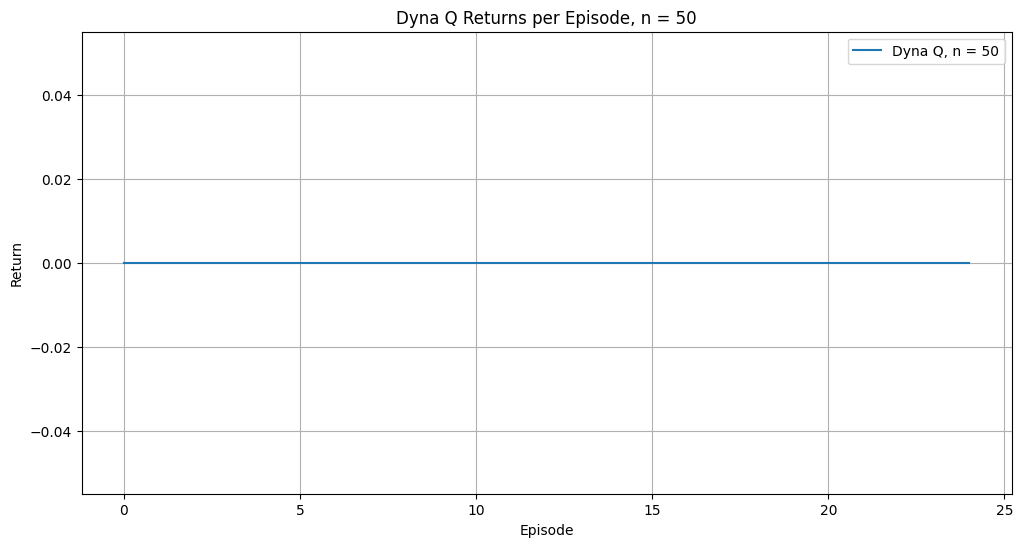

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [94]:
import gymnasium as gym
import numpy as np
import random
import gymnasium.envs.toy_text
import gymnasium as gym
gym.make(
    'FrozenLake-v1')
#     desc=None,
#     map_name="4x4",
#     is_slippery=True,
#     success_rate=1.0/3.0,
#     reward_schedule=(1, 0, 0)
# )

def dynaQ(N_sim = 50, n_episodes = 25):

  alpha = 0.1
  gamma = 0.95
  n_actions = env.action_space.n
  n_states = env.observation_space.n
  Q = np.zeros((n_states, n_actions))
  dyna_q_learning_rewards = []
  Experience = []
  eps = 1

  max_steps = 100

  # epsilon schedule (episode-wise exponential decay)
  eps_min, eps_max, eps_decay = 0.05, 1.0, 5e-3

  def eps_greedy(s, eps):
      if random.random() < eps:
          return env.action_space.sample()
      return int(np.argmax(Q[s]))

  for ep in range(n_episodes):
      s, _ = env.reset()
      # decay epsilon per episode
      # eps = eps_min + (eps_max - eps_min) * np.exp(-eps_decay * ep)
      eps = max(eps_min, (ep/n_episodes)*eps_max)  # uniform per-step decay

      if ep>5:
        eps = 0

      episode_reward = 0

      a = eps_greedy(s, eps)

      for t in range(max_steps):
          s_next, r, terminated, truncated, _ = env.step(a)
          Experience.append((s, a, r, s_next))


          # if ep == n_episodes - 1:
          #     q_learning_rewards.append(r)

          episode_reward += r

          # Q update
          if terminated or truncated:
              Q[s, a] += alpha * (r - Q[s, a])
              break

          # choose a_next as the best action for Q update
          a_next = np.argmax(Q[s_next])

          # Q update
          td_target = r + gamma * Q[s_next, a_next]
          Q[s, a] += alpha * (td_target - Q[s, a])

          for _ in range(N_sim):
              s_sim, a_sim, r_sim, s_next_sim = random.choice(Experience)
              a_next = np.argmax(Q[s_next_sim])
              td_target = r_sim + gamma * Q[s_next_sim, a_next]
              Q[s_sim, a_sim] += alpha * (td_target - Q[s_sim, a_sim])

          a_next_actual = eps_greedy(s_next, eps)
          s, a = s_next, a_next_actual

      dyna_q_learning_rewards.append(episode_reward)


  plt.figure(figsize=(12, 6))
  plt.plot(dyna_q_learning_rewards, label=f"Dyna Q, n = {N_sim}")
  plt.xlabel("Episode")
  plt.ylabel("Return")
  plt.title(f"Dyna Q Returns per Episode, n = {N_sim}")
  plt.legend()
  plt.grid(True)
  plt.show()
  return(dyna_q_learning_rewards)


dynaQ()
